# 1. Environment Configuration and Warning Suppression

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 2. Downloading and Extracting the Fruits-360 Dataset

In [ ]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)

        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")

    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")


Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'


Directory structure

Ensure that your data set is organized as follows:

```

├── train/
│   ├── Class1/
│   ├── Class2/
│   ├── Class3/
│   └── (other classes...)
├── val/
│   ├── Class1/
│   ├── Class2/
│   ├── Class3/
│   └── (other classes...)
└── test/
    ├── Class1/
    ├── Class2/
    ├── Class3/
    └── (other classes...)

# Data Augmentation and Generator Creation

In [ ]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layers in base_model.layers:
    layers.trainable = False

model = Sequential(
    [
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(train_generator.num_classes,activation="softmax")
    ]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Compiling the Base Model

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Initial Training (Feature Extraction Phase)

In [ ]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2 , patience=2, min_lr=1e-6 ,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

set_global_policy('mixed_float16')

steps_per_epoch = 50
validation_steps = 10

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.1403 - loss: 3.1655 - val_accuracy: 0.1500 - val_loss: 2.6943 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.4780 - loss: 1.7872 - val_accuracy: 0.3187 - val_loss: 2.2587 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5842 - loss: 1.3278 - val_accuracy: 0.5500 - val_loss: 1.7966 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6848 - loss: 1.0661 - val_accuracy: 0.5500 - val_loss: 1.4722 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7188 - loss: 0.8815 - val_accuracy: 0.6562 - val_loss: 1.1678 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7345 - loss: 0.8586 - val_accuracy: 0.6687 - val_loss: 1.0874 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7794 - loss: 0.7450 - val_a

# Fine-Tuning Strategy: Unfreezing Top Layers

In [ ]:
from tensorflow.keras.optimizers import Adam

num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")


for layer in base_model.layers[-5:]:
    layer.trainable = True

for layers in base_model.layers:
    if isinstance(layers, tf.keras.layers.BatchNormalization):
        layers.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

The base model has 19 layers.


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,853,208 (56.66 MB)

 Trainable params: 7,217,432 (27.53 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

In [ ]:
# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8965 - loss: 0.3605 - val_accuracy: 0.8938 - val_loss: 0.3060 - learning_rate: 1.0000e-06
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8976 - loss: 0.3685 - val_accuracy: 0.9250 - val_loss: 0.2924 - learning_rate: 1.0000e-06
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8705 - loss: 0.3846 - val_accuracy: 0.9312 - val_loss: 0.2783 - learning_rate: 1.0000e-06
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8777 - loss: 0.3859 - val_accuracy: 0.9438 - val_loss: 0.2316 - learning_rate: 1.0000e-06
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8634 - loss: 0.3759 - val_accuracy: 0.9125 - val_loss: 0.3019 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 4.


# Model Evaluation on Test Data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9449 - loss: 0.2517
Test Accuracy: 0.94
Test Loss: 0.27


# Visualizing Performance: Feature Extraction vs. Fine-Tuning

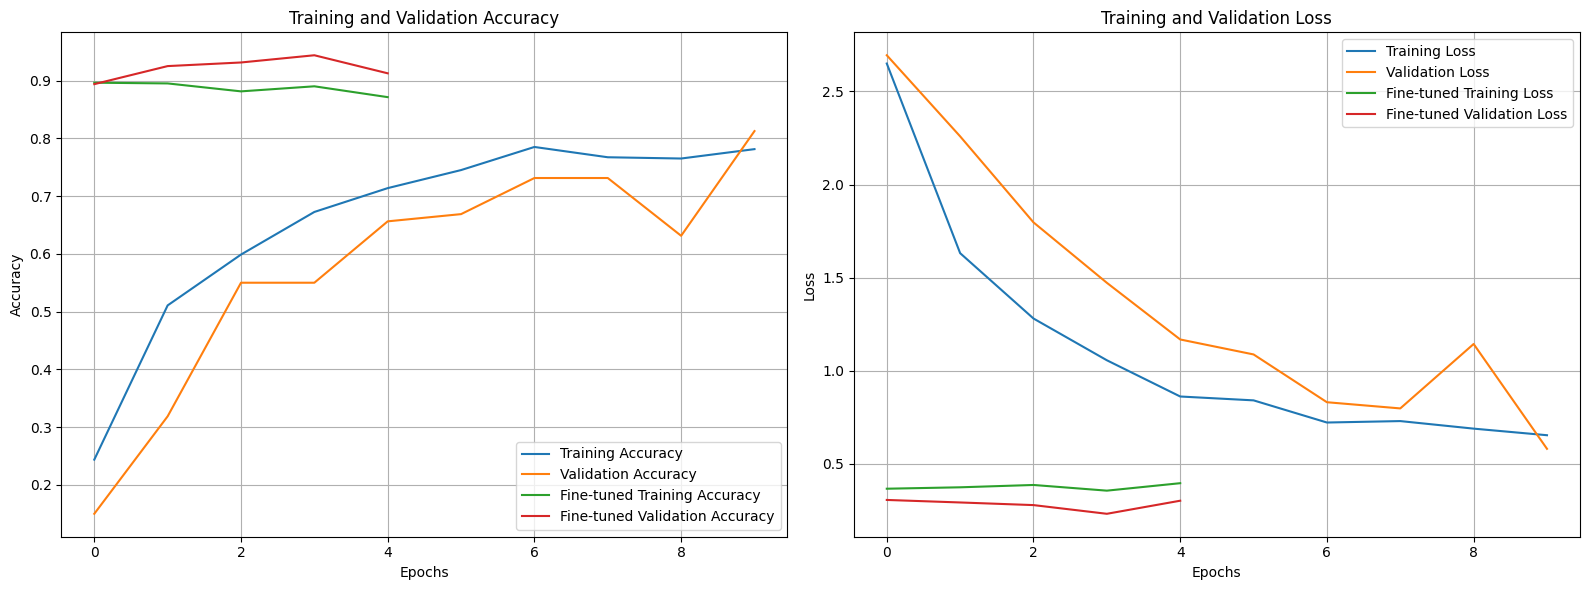

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
axes[0].plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
axes[1].plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Testing

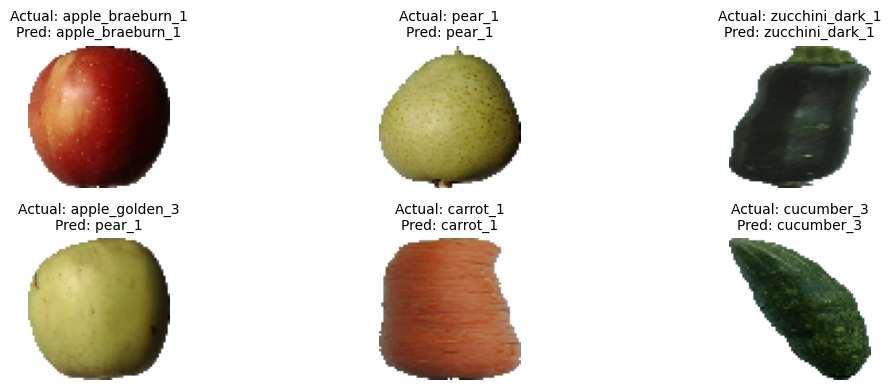

In [ ]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters
actual_count = Counter()
predicted_count = Counter()

# Function to convert predicted index to class name
def get_class_name_from_index(predicted_index, class_index_mapping):
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"

# Improved visualization function
def visualize_predictions(img_paths, class_index_mapping, model, cols=3, figsize=(12, 4)):
    """
    Visualize multiple images with their actual and predicted classes in a grid.

    Args:
        img_paths (list): List of image file paths.
        class_index_mapping (dict): Mapping of class names to indices.
        model (tf.keras.Model): Trained model to make predictions.
        cols (int): Number of columns in the grid.
        figsize (tuple): Figure size.

    Returns:
        actual_count, predicted_count (Counter): Counts of actual and predicted classes.
    """
    n_images = len(img_paths)
    rows = (n_images + cols - 1) // cols  # Calculate number of rows needed
    plt.figure(figsize=figsize)

    for i, img_path in enumerate(img_paths):
        # Get actual class from folder name
        actual_class = os.path.basename(os.path.dirname(img_path))

        # Load and preprocess image
        img = load_img(img_path, target_size=(64, 64))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict class
        prediction = model.predict(img_array, verbose=0)
        predicted_index = np.argmax(prediction, axis=-1)[0]
        predicted_class = get_class_name_from_index(predicted_index, class_index_mapping)

        # Update counters
        actual_count[actual_class] += 1
        predicted_count[predicted_class] += 1

        # Plot image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {actual_class}\nPred: {predicted_class}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return actual_count, predicted_count

# Example usage
class_index_mapping = train_generator.class_indices
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/zucchini_dark_1/r0_103.jpg',
    '/content/fruits-360-original-size/fruits-360-original-size/Test/apple_golden_3/r0_103.jpg',
    '/content/fruits-360-original-size/fruits-360-original-size/Test/carrot_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]


actual_count, predicted_count = visualize_predictions(sample_images, class_index_mapping, model)